Sascha Spors,
Professorship Signal Theory and Digital Signal Processing,
Institute of Communications Engineering (INT),
Faculty of Computer Science and Electrical Engineering (IEF),
University of Rostock, Germany

Tutorial Digital Signal Processing (Course #24505),
**FIR Filter**,
Winter Semester 2019/20

WIP...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Circle
from scipy import signal

In [2]:
def zplane_plot(ax, z, p):
    """Realize a zplane plot.

    input:
    ax...axes handle
    z...zeros
    p...poles
    output:
    zplane plot into ax
    """
    if ax is None:
        ax = plt.gca()

    ax.axvline(0, color="C7")
    ax.axhline(0, color="C7")
    unit_circle = Circle((0, 0), radius=1, fill=False,
                         color="k", linestyle="-", alpha=1)
    ax.add_patch(unit_circle)

    ax.plot(np.real(z), np.imag(z),
            "o", label="zero",
            color="C0", fillstyle="none",
            markersize=10, markeredgewidth=2)
    ax.plot(np.real(p), np.imag(p),
            "x", label="pole",
            color="C1", fillstyle="none",
            markersize=10, markeredgewidth=2)

    if len(z) == 2 and len(p) == 2:
        if (z[0]-z[1]) == 0.:
            ax.text(np.real(z[0])+0.05, np.imag(z[0])+0.05, '2', color='C0')
        if (p[0]-p[1]) == 0.:
            ax.text(np.real(p[0])+0.05, np.imag(p[0])-0.1, '2', color='C1')
    else:
        if len(z) != 1 and len(p) != 1:
            ax.text(-1.1, -1.1, 'warning: multiple zeros or poles might be in the pzmap')

    ax.set_xscale("linear")
    ax.set_yscale("linear")
    ax.set_xlabel(r'$\Re(z)$', color="k")
    ax.set_ylabel(r'$\Im(z)$', color="k")
    ax.set_title("Pole/zero map",
                 color="k")
    ax.axis("equal")
    ax.set_xticks(np.arange(-2, 3)/2)
    ax.set_yticks(np.arange(-2, 3)/2)
    ax.legend(loc="best")
    ax.grid(True, which="both", axis="both",
            linestyle="-", linewidth=0.5, color=(0.8, 0.8, 0.8))


def bode_plot(b, N=2**10, fig=None):  # for FIR only
    if fig is None:
        fig = plt.figure()
        
    a = np.zeros(len(b))  # some scipy packages need len(a)==len(b)
    a[0] = 1
    
    p = np.roots(a)
    z = np.roots(b)

    print('#poles:', len(p), '\n poles:', p,
          '\n#zeros:', len(z), '\n zeros:', z)

    W, Hd = signal.freqz(b, a, N, whole=True)
    if Hd[0] == 0:
        Hd[0] = 1e-15  # avoid zero at DC for plotting dB

    gs = fig.add_gridspec(2, 2)
    # magnitude
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(W/np.pi, np.abs(Hd), "C7",
             label=r'$|H(\Omega)|$)',
             linewidth=2)
    ax1.set_xlim(0, 2)
    ax1.set_xticks(np.arange(0, 9)/4)
    ax1.set_xlabel(r'$\Omega / \pi$', color='k')
    ax1.set_ylabel(r'$|H|$', color='k')
    ax1.set_title("Magnitude response", color='k')
    ax1.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color=(0.8, 0.8, 0.8))

    # phase
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(W/np.pi, (np.angle(Hd)*180/np.pi), "C7",
             label=r'$\mathrm{angle}(H('r'\omega))$',
             linewidth=2)
    ax2.set_xlim(0, 2)
    ax2.set_xticks(np.arange(0, 9)/4)
    ax2.set_xlabel(r'$\Omega / \pi$', color='k')
    ax2.set_ylabel(r'$\angle(H)$ / deg', color='k')
    ax2.set_title("Phase response", color='k')
    ax2.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color=(0.8, 0.8, 0.8))

    # zplane
    ax3 = fig.add_subplot(gs[0, 1])
    zplane_plot(ax3, z, p)

    # impulse response
    N = 2**3
    k = np.arange(0, N)
    x = np.zeros(N)
    x[0] = 1
    h = signal.lfilter(b, a, x)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.stem(k, h, linefmt='C7', markerfmt='C7o',
             basefmt='C7:', use_line_collection=True)
    ax4.set_xlabel(r'$k$')
    ax4.set_ylabel(r'$h[k]$')
    ax4.set_title('Impulse Response')
    ax4.grid(True, which="both", axis="both", linestyle="-",
             linewidth=0.5, color=(0.8, 0.8, 0.8))


a = [1, 0, 0]
figsize = (12, 9)

# Filter Fundamentals

The transfer function of digital filters can be expressed in the $z$-domain as
\begin{equation}
H(z)=\frac{Y(z)}{X(z)} = \frac{\sum\limits_{m=0}^M b_mz^{-m}}{\sum\limits_{n=0}^N a_nz^{-n}}
=\frac{b_0z^0+b_1z^{-1}+b_2z^{-2}+...+b_Mz^{-M}}{a_0z^0+a_1z^{-1}+a_2z^{-2}+...+a_Nz^{-N}}
\end{equation}

with input $X(z)$ and output $Y(z)$. Real input signals $x[k]$ that should end up as real output signals $y[k]$ (in terms of signal processing fundamentals this is a special case, though most often needed in practice) require $b,a\in\mathbb{R}$. This only yields the following types of zeros and poles

- single, multiple real valued
- single or multiple conjugate-complex pairs

Furthermore, in practice we most often aim at (i) causal and (ii) bounded input, bound output (BIBO) stable LTI systems, which requires (i) $M \leq N$ and (ii) poles inside the unit circle. If all poles and zeros are inside the unit circle then the system is minimum-phase and thus straightforwardly invertible.

Further concepts related to the transfer function are:

- Analysis of the transfer characteristics is done by the DTFT
$H(z=\mathrm{e}^{\mathrm{j}\Omega})$, i.e. evaluation on the unit circle.

- We use $a_0=1$ according to convention in many textbooks.

- The convention for arraying filter coefficients is straightforward with Python index starting at zero:
$b_0=b[0]$, $b_1=b[1]$, $b_2=b[2]$, ..., $a_0=a[0]=1$, $a_1=a[1]$, $a_2=a[2]$.

- A **non-recursive** system with $a_1,a_2,a_3,...=0$ exhibits a **finite
impulse response** (FIR), note: $a_0=1$ for output though.

- A **recursive system** exhibits at least one $a_{n\geq1}\neq0$. Because
of the feedback of the output into the system, a potentially **infinite impulse
response** (IIR) results.

- The output signal of a non-recursive system can be calculated by linear
convolution 

\begin{equation}
y[k] = \sum\limits_{m=0}^{M} h[k] x[k-m].
\end{equation}

of the finite impulse response $h[k]$ and the input signal $x[k]$. For a recursive system, the difference equation

\begin{equation}
y[k] = b_0 x[k] + b_1 x[k-1] + b_2 x[k-2] + ... + b_M x[k-M] -a_1 y[k-1] - a_2 y[k-2] - a_3 y[k-3] - ... - a_N y[k-N]
\end{equation}

needs to be implemented.

Please note: A recursive system can still have a finite impulse responses, but those are very special cases. Therefore, literature usually makes the distinction for FIR being non-recursive and IIR being recursive systems.

# FIR Filter

The non-recursive system has transfer function

\begin{equation}
H(z) = \frac{Y(z)}{X(z)} = \sum\limits_{m=0}^M b_mz^{-m}
=b_0z^0+b_1z^{-1}+b_2z^{-2}+...+b_Mz^{-M}.
\end{equation}

with difference equation 

\begin{equation}
y[k] = b_0 x[k] + b_1 x[k-1] + b_2 x[k-2] + ... + b_M x[k-M],
\end{equation}

from which we can directly observe that the impulse response (i.e. for $x[k] = \delta[k]$) is

\begin{equation}
h[k] = b_0 \delta[k] + b_1 \delta[k-1] + b_2 \delta[k-2] + ... + b_M \delta[k-M].
\end{equation}

This constitutes $h[k]$ as the coefficients $b_k$ at sample instances $k$.

The impulse response for this non-recursive system has always finite length of $M+1$ samples.

Usually this filter type is referred to as finite impulse response (FIR) filter in literature.

Very special recursive systems/filters can produce FIRs as well. This is however so rare, that
the common link FIR filter == non-recursive system is predominantly made.

The filter **order** is $M$, the **number of coefficients** $b$ is $M+1$. Be cautious here and consistent with the naming, it sometimes gets confusing. Especially for linear phase filters (see below) it is really important if $M$ or $M+1$ is even/odd.

Sometimes the **number of taps** $M+1$ is stated (rather than calling this number of coefficients). This refers to tapping $M+1$ delayed instances of the signal input signal $x$ to calculate the filtered output signal $y$.

## Poles / Zeros of FIR Filter

To calculate poles and zeros of the transfer function $H(z)$ it is meaningful to rewrite

\begin{equation}
H(z) = \sum\limits_{m=0}^M b_mz^{-m} \frac{z^M}{z^M}
=(b_0z^0+b_1z^{-1}+b_2z^{-2}+...+b_Mz^{-M}) \frac{z^M}{z^M}.
\end{equation}

This reveals that FIR filters have a $M$-fold pole at $z_\infty = 0$. This is always the case for non-recursive systems and besides the finite impulse response explains why these systems are always stable: poles in the origin are harmless, since they equally contribute to all frequencies.

For the zeros, the equation

\begin{equation}
\sum\limits_{m=0}^M b_m z^{-m} z^M = b_M z^M+b_1 z^{M-1}+b_2 z^{M-2}+...+b_M = 0
\end{equation}

needs to be solved. Recall from above, that for $b\in\mathbb{R}$ only real or conjugate complex zeros can occur, but never single complex zeros. The $M$-th order polynomial has $M$ zeros. The fundamental concept (just as was it with window design for the DFT) is to place the $M$ available zeros in the $z$-plane such that a target magnitude **and** phase response results, which suits the desired filter characteristics.

It is important to note that (contrary to most IIR filters) the magnitude and phase response can be separately controlled.

In the referenced [english monographs](../index.ipynb) you'll find information on specific FIR design techniques such as

- FIR design with windowing method
- FIR design as minimax optimization problem
- FIR design of frequency sampling a DTFT spectrum

These are well covered in Scipy and Matlab. We will later discuss the windowing method. 

For FIR filters the magnitude at $\Omega=0$ and $\Omega=\pi$ can be straightforwardly evaluated with the following equations. 

The DC magnitude is obtained by 

\begin{align}
g_0 = \sum_{k=0}^{M} h[k].
\end{align}

The magnitude at $\Omega=\pi$ (i.e. at half the sampling frequency) is obtained by 

\begin{align}
g_\pi = \sum_{k=0}^{M} (-1)^k h[k].
\end{align}

## FIR Examples with M=1 and M=2

It is meaningful to discuss a very simple case of FIR in detail. Once getting familiar with the underlying principles and concepts it is comparably easy to increase the FIR filter order and see how it gets.

Almost all important issues on FIRs can be explained with

- the filter order $M=1$, thus number of coefficients is $M+1=2$ and with
- the filter order $M=2$, thus number of coefficients is $M+1=3$.

The calculus of zeros is not tedious and can be performed manually then. Furthermore, the impact of $M$ zeros in the $z$-plain is comparably easy linked to the magnitude and phase response.

### Example FIR M=1, b0=1, b1=1

This is the most simple case of an FIR.

The squared magnitude response can be given analytically as ( make use of $\mathrm{e}^{-\mathrm{j}\Omega}=\cos(\Omega)-\mathrm{j}\sin(\Omega)$ ) 

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = |1 + \mathrm{e}^{-\mathrm{j}\Omega}|^2 = 2 \cos(\Omega) + 2 = 4 \cos^2(\frac{\Omega}{2}).
\end{equation}

Thus the magnitude response is 

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 2 |\cos(\frac{\Omega}{2})|,
\end{equation}

which is confirmed by the plot (left, top). The magnitude response exhibits lowpass characteristics.

The impulse response is simply

\begin{align}
h[k] = b_0 \delta[k] + b_1\delta[k-1],
\end{align}

confirmed by the plot (right, bottom).

For the $M$-th order polynomial the $M=1$ zero is easy to evaluate

\begin{equation}
b_0 z^1+b_1 z^{0} = z+1 = 0\to z_{0,1} = -1
\end{equation}

There is $M=1$ pole in the origin, i.e. $z_{\infty,1} = 0$. Zero and pole are shown in the $z$-plane (right, top).

This FIR has special characteristics on the phase response, namely it is linear phase (type II), see discussion below.

In the present case $g_0=2$ and $g_\pi=0$.

#poles: 1 
 poles: [0.] 
#zeros: 1 
 zeros: [-1.]


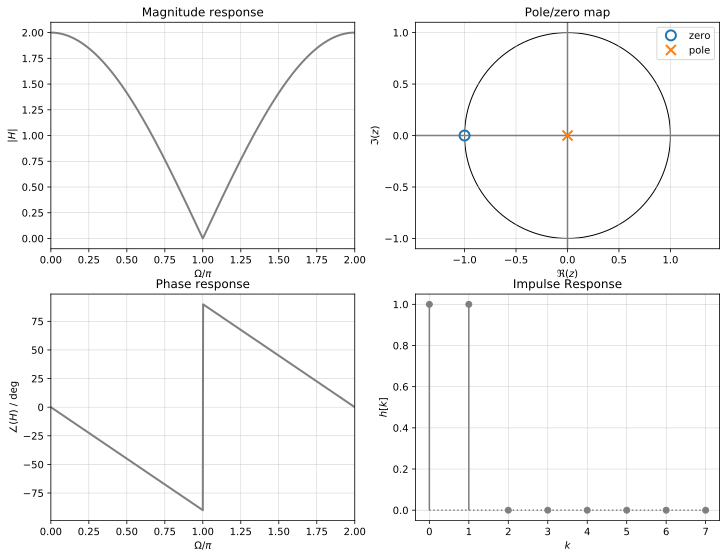

In [3]:
b = [1, 1]  # linear phase FIR Type II
bode_plot(b, fig=plt.figure(figsize=figsize))

### Example FIR M=1, b0=1, b1=-1

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 4 \sin^2(\frac{\Omega}{2}).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 2 |\sin(\frac{\Omega}{2})|.
\end{equation}

$z_{\infty,1}=0$,
$z_{0,1}=1$

$g_0=0$,
$g_\pi=2$

This is a simple **highpass**.

#poles: 1 
 poles: [0.] 
#zeros: 1 
 zeros: [1.]


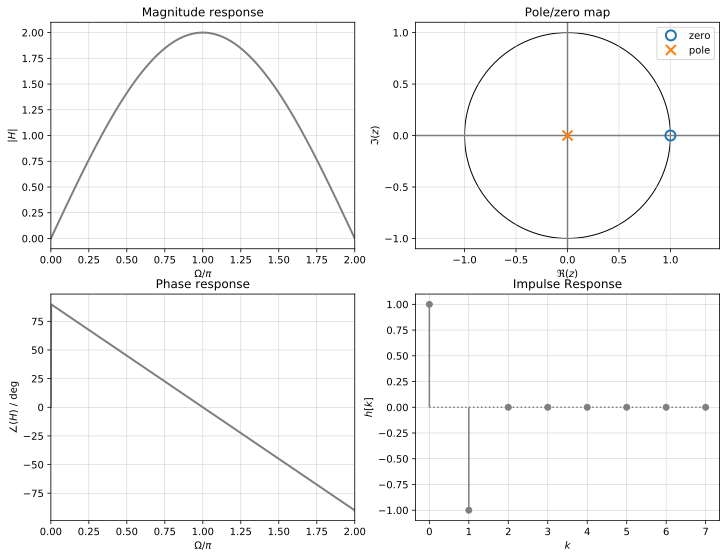

In [4]:
b = [1, -1]  # linear phase FIR Type IV
bode_plot(b, fig=plt.figure(figsize=figsize))

### Example FIR M=2, b0=1, b1=0, b2=1

Filter order $M=2$, number of coefficients $M+1=3$, although one coefficient is zero.

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 4 \cos^2(\Omega).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 2 |\cos(\Omega)|.
\end{equation}

double pole in origin $z_{\infty,1,2}=0$

conjugate-complex pair $z_{0,1,2}=\pm \mathrm{j}$

$g_0=2$,
$g_\pi=2$

This is a simple **bandstop**.

#poles: 2 
 poles: [0. 0.] 
#zeros: 2 
 zeros: [-0.+1.j  0.-1.j]


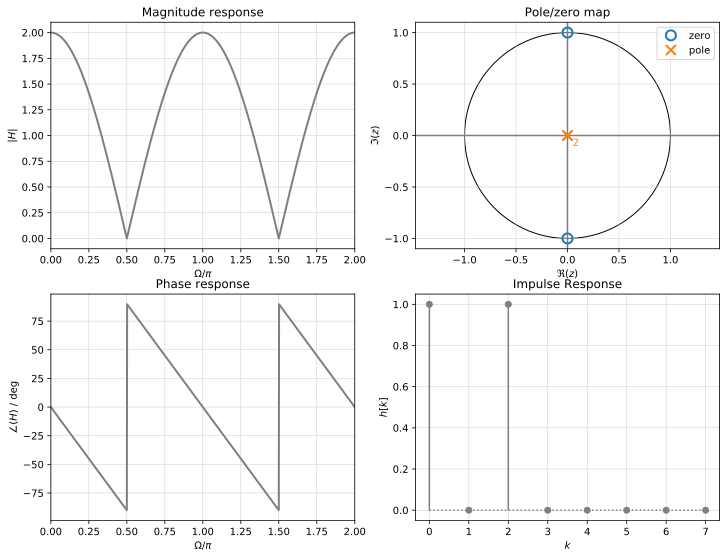

In [5]:
b = [1, 0, 1]  # linear phase FIR Type I, the zero in between counts as coeff
bode_plot(b, fig=plt.figure(figsize=figsize))

### Example FIR M=2, b0=1, b1=0, b2=-1

Filter order $M=2$, number of coefficients $M+1=3$, although one coefficient is zero.

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 4 \sin^2(\Omega).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 2 |\sin(\Omega)|.
\end{equation}

double pole in origin $z_{\infty,1,2}=0$

two single real zeros $z_{0,1,2}=\pm 1$

$g_0=0$,
$g_\pi=0$

This is a simple **bandpass**.

#poles: 2 
 poles: [0. 0.] 
#zeros: 2 
 zeros: [-1.  1.]


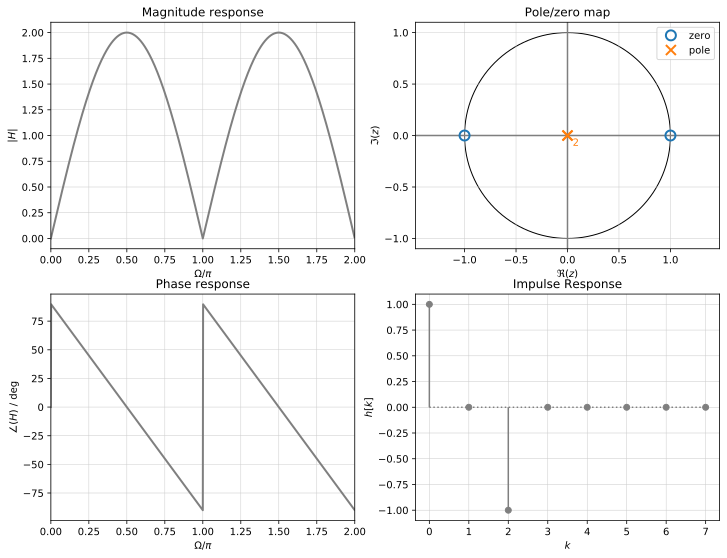

In [6]:
b = [1, 0, -1]  # linear phase FIR Type III, the zero in between counts as coeff
bode_plot(b, fig=plt.figure(figsize=figsize))

### Example FIR M=2, b0=1, b1=2, b2=1

Filter order $M=2$, number of coefficients $M+1=3$.

The manual derivation of analytic magnitude response starts to get tedious, however:

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 16 \cos^4(\Omega).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 4 \cos^2(\Omega).
\end{equation}

double pole in origin $z_{\infty,1,2}=0$

double real zero $z_{0,1,2}=-1$

$g_0=4$,
$g_\pi=0$

This is a simple **lowpass**, which a little smoother characteristics.

#poles: 2 
 poles: [0. 0.] 
#zeros: 2 
 zeros: [-1. -1.]


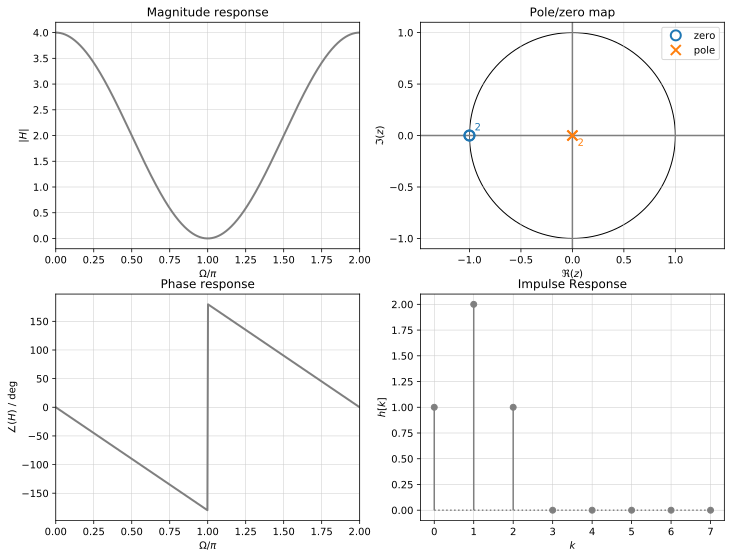

In [7]:
b = [1, 2, 1]  # linear phase FIR Type I
bode_plot(b, fig=plt.figure(figsize=figsize))

### Example FIR M=2, b0=1, b1=-2, b2=1

By reversing the sign for $b_1$ compared to the just discussed lowpass we obtain a highpass.

Filter order $M=2$, number of coefficients $M+1=3$.

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})|^2 = 16 \sin^4(\Omega).
\end{equation}

\begin{equation}
|H(\mathrm{e}^{\mathrm{j}\Omega})| = 4 \sin^2(\Omega).
\end{equation}

double pole in origin $z_{\infty,1,2}=0$

double real zero $z_{0,1,2}=0$

$g_0=0$,
$g_\pi=4$

This **highpass** has also slightly smoother characteristics.

#poles: 2 
 poles: [0. 0.] 
#zeros: 2 
 zeros: [1. 1.]


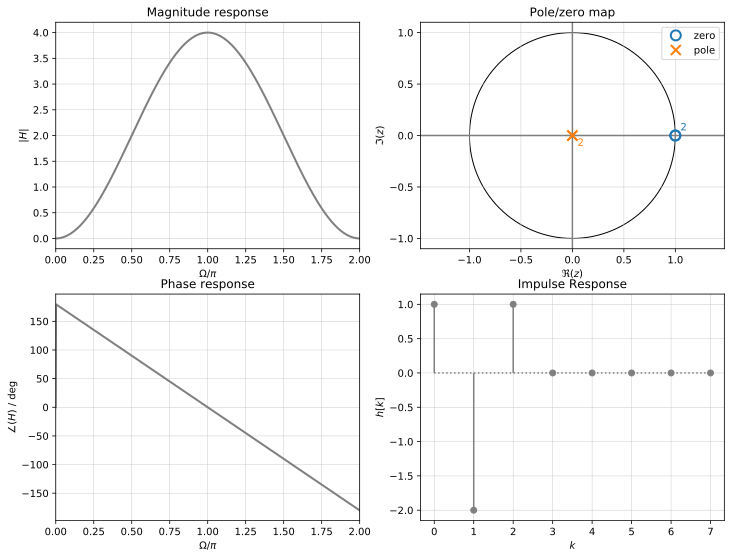

In [8]:
b = [1, -2, 1]  # linear phase FIR Type I
bode_plot(b, fig=plt.figure(figsize=figsize))

### Example FIR M=2, b0=1, b1=1, b2=1/2

So, far all zeros were aligned **on** the unit circle. We are not restricted to that locations, as long as we ensure positioning only real and complex-conjugate pairs in the $z$-plane.

Filter order $M=2$, number of coefficients $M+1=3$.

double pole in origin $z_{\infty,1,2}=0$

conjugate-complex pair $z_{0,1,2}=-\frac{1}{2}\pm \frac{1}{2}\mathrm{j}$

$g_0=\frac{5}{2}$,
$g_\pi=\frac{1}{2}$

This 2nd order FIR **lowpass** becomes a little more complicated and has a ripple in the stopband. Most important, since the zeros are **not** on the unit circle the magnitude response exhibits **no** exact zeros. Second morst important: the impulse response does not have a symmetry of linear-phase filter types I-IV, thus it is a **non-linear-phase** FIR. In fact, since poles and zeros are all within unit circle, the filter is minimum-phase.

#poles: 2 
 poles: [0. 0.] 
#zeros: 2 
 zeros: [-0.5+0.5j -0.5-0.5j]


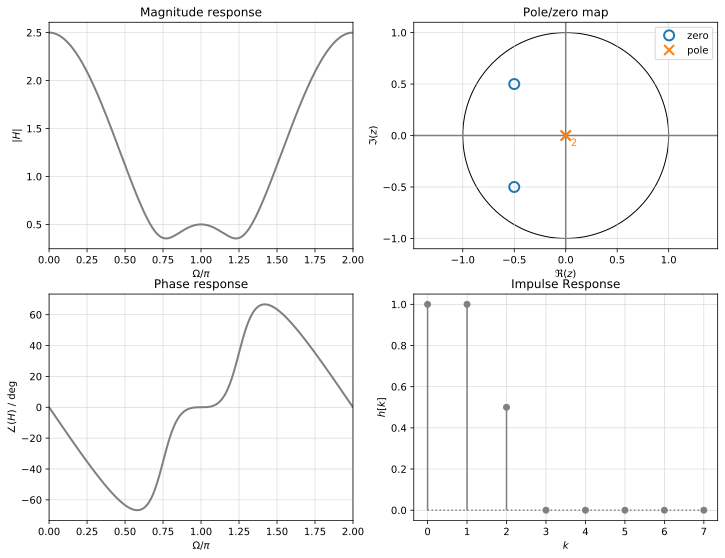

In [9]:
b = [1, 1, 1/2]  # NON linear phase FIR, since there is no symmetry in the IR
# minimum phase since all poles and zeros are inside unit circle
# this system has a stable inverse (pole/zero reversal, 1/gain factor)
bode_plot(b, fig=plt.figure(figsize=figsize))

### Example FIR M=2, b0=1/2, b1=1, b2=1

We can even aligne zeros outside the unit circle.

Filter order $M=2$, number of coefficients $M+1=3$.

double pole in origin $z_{\infty,1,2}=0$

conjugate-complex pair $z_{0,1,2}=-1\pm \mathrm{j}$

$g_0=\frac{5}{2}$,
$g_\pi=\frac{1}{2}$

This 2nd order FIR **lowpass** has the same magnitude response as the above lowpass. This is due to the fact that in both cases their zeros have same distance to the unit circle.

Obviously, this filter is also non-linear-phase, but also not minimum-phase. In fact, the filter is maximum-phase, i.e. the largest phase excess for the given magnitude response. Due to its maximum-phase, this FIR cannot be inverted, since then poles would lie outside the unit circle, yielding a non-stable system.

#poles: 2 
 poles: [0. 0.] 
#zeros: 2 
 zeros: [-1.+1.j -1.-1.j]


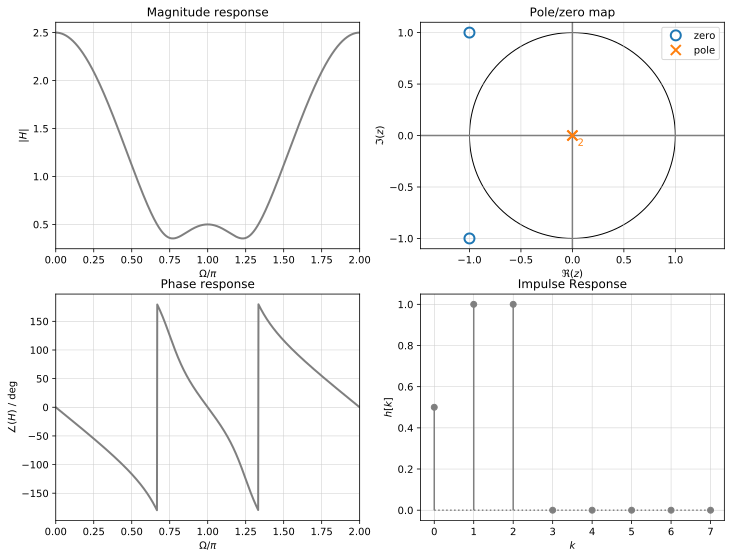

In [10]:
b = [0.5, 1, 1]  # NON linear phase FIR, since there is no symmetry in the IR
# same magnitude as b = [1, 1, 1/2]
# but also NON minimum phase since zeros outside unit-circle
# rather maximum-phase
# this system has NO stable inverse
bode_plot(b, fig=plt.figure(figsize=figsize))

## FIR Filters with Linear Phase

A linear-phase FIR filter exhibits the DTFT spectrum

\begin{equation}
H(\mathrm{e}^{\mathrm{j}\Omega}) = A(\mathrm{e}^{\mathrm{j}\Omega})\,\mathrm{e}^{-\mathrm{j}\,\alpha\,\Omega}\,\mathrm{e}^{\mathrm{j}\,\beta}
\end{equation}

with the magnitude spectrum $A(\mathrm{e}^{\mathrm{j}\Omega})\in\mathbb{R}$ and the phase $\mathrm{e}^{-\mathrm{j}\,\alpha\,\Omega}\,\mathrm{e}^{\mathrm{j}\,\beta}$ with $\alpha,\beta\in\mathbb{R}^+$.

There are four different basic types of linear-phase FIR filters that differ by the symmetry of the impulse response and the length of the finite impulse response.

The constant group delay in samples for all FIR filter types is $\frac{M}{2}=\text{const}$, which leads to half sample values for odd $M$.

### FIR Type I

- filter order $M$ even, odd number $M+1$ of filter coefficients $b$
- even symmetry of the impulse response $h[k]=h[M-k]$
- $\beta=0,\,\pi$
- No fixed zeros, therefore all filter types are possible

### FIR Type II

- filter order $M$ odd, even number $M+1$ of filter coefficients $b$
- even symmetry of the impulse response $h[k]=h[M-k]$
- $\beta=0,\,\pi$
- Fixed zero $H(z=-1)=0$, i.e. zero at $\Omega=\pi$, $f=\frac{f_s}{2}$.
- Therefore, only a lowpass or a bandpass can be realized properly.

### FIR Type III
- filter order $M$ even, odd number $M+1$ of filter coefficients $b$
- odd symmetry of the impulse response $h[k]=-h[M-k]$
- $\beta=\frac{\pi}{2},\,\frac{3}{2}\pi$
- Fixed zeros $H(z=1)=0$ and $H(z=-1)=0$, i.e. zeros at $\Omega=0$, $f=0$ and
$\Omega=\pi$, $f=\frac{f_s}{2}$.
- Therefore, only a bandpass can be realized properly.

### FIR Type IV
- filter order $M$ odd, even number $M+1$ of filter coefficients $b$
- odd symmetry of the impulse response $h[k]=-h[M-k]$
- $\beta=\frac{\pi}{2},\,\frac{3}{2}\pi$
- Fixed zero $H(z=1)=0$, i.e. zero at $\Omega=0$, $f=0$.
- Therefore, only a highpass or a bandpass can be realized properly.

Bandpasses are possible with all four FIR filter types.

Since FIR type I has no restrictions it might be the favorable choice, except you wish to place zeros explicitly at $\Omega=0,\pi$. Then the other types might be of interest.

![LinPhase_FIR_Types.png](LinPhase_FIR_Types.png)

In [11]:
def plot_windowed_FIR_design():
    hw = h*w
    W = np.arange(0, 2**10) * 2*np.pi / 2**10
    [_, H] = signal.freqz(h, a=1, worN=W)
    [_, Hw] = signal.freqz(hw, a=1, worN=W)
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(k, h, 'C3o-', label='rectangular windowed FIR h[k]')
    plt.plot(k, w, 'C7o-', label='Kaiser Bessel window w[k]')
    plt.plot(k, hw, 'C2o-', label='Kaiser-Bessel windowed FIR hw[k]')
    plt.xlabel('k')
    plt.title('Impulse responses and window')
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 1, 2)
    plt.plot([W[0]/np.pi, W[-1]/np.pi], [0, 0], 'C7')
    plt.plot([W[0]/np.pi, W[-1]/np.pi], [-6, -6], 'gold')
    plt.plot([W[0]/np.pi, W[-1]/np.pi], [-21, -21], 'C3')
    plt.plot([W[0]/np.pi, W[-1]/np.pi],
             [StopBandMaxLevel, StopBandMaxLevel], 'C2')
    plt.plot([Wc/np.pi, Wc/np.pi], [StopBandMaxLevel, 0],
             'gold', label=r'-6dB @ $\Omega_c$')
    plt.plot(W/np.pi, 20*np.log10(np.abs(H)), color='C3',
             label='rectangular windowed FIR')
    plt.plot(W/np.pi, 20*np.log10(np.abs(Hw)), color='C2',
             label='Kaiser-Bessel windowed FIR')
    plt.xlim((0, 2))
    plt.yticks(np.arange(-6-12*8, 12, 12))
    plt.xlabel(r'$\Omega / \pi$')
    plt.ylabel(r'$20\lg|H(\Omega)|$ / dB')
    plt.title('Magnitude response')
    plt.legend()
    plt.grid(True)

## Windowed FIR Design Low-Pass

The ideal lowpass (i.e. zero-phase and infinite impulse response) with cutoff frequency $0 < \Omega_c < \pi$ is given by inverse DTFT as

\begin{equation}
h[k] = \frac{1}{2 \pi} \int\limits_{-\Omega_c}^{+\Omega_c} 1 \cdot \mathrm{e}^{+\mathrm{j} \Omega k} \mathrm{d}\Omega.
\end{equation}

The analytic solution is

\begin{equation}
h[k]=\frac{\sin\left(\Omega_c k \right)}{\pi k}.
\end{equation}

In order to obtain a practical (finite order M) and causal (peak at M/2) we can shift this impulse response by $M/2$ (time delay)

\begin{equation}
h[k]=\frac{\sin\left(\Omega_c\left(k-\frac{M}{2}\right)\right)}{\pi\left(k-\frac{M}{2}\right)}
\end{equation}

and consider only the values for $0\leq k \leq M$, so filter order $M$, filter length $M+1$. Furthermore, we require that $M$ is even to obtain linear-phase type I. Then we can simplify

\begin{equation}
h[k]=\begin{cases}
\frac{\sin\left(\Omega_c\left(k-\frac{M}{2}\right)\right)}{\pi\left(k-\frac{M}{2}\right)} &\quad k\neq \frac{M}{2}\\
\frac{\Omega_c}{\pi} &\quad k=\frac{M}{2}.
\end{cases}
\end{equation}

The plain cut out (i.e. a rectangular window) towards a FIR yields

- on the one hand, the steepest roll-off for $\Omega>\Omega_c$ towards the first zero in the magnitude response
- but on the other hand also the worst stop band damping in the magnitude response (maximum stopband level is only about -21 dB)

Most often, larger maximum stopband level is desired under acceptance of less steep initial roll-off. This can be achieved with other window functions. A very well suited window for this filter design task is the Kaiser-Bessel window. Kaiser figured out that a certain maximum stopband level (usually this is here the first side lobe) can be controlled by the parameter $\beta$. This of course holds only if $M$ is chosen large enough to obtain such a damping at all.

For a maximum stopband level $\gamma<-50$ in dB, the approximation

\begin{equation}
\beta_\mathrm{Kaiser-Bessel-Window} = -0.1102\,(\gamma+8.7)
\end{equation}

was invented.

Then, with an accordingly designed window for $0\leq k \leq M$, the improved FIR is given as

\begin{equation}
h_w[k] = w[k] \cdot h[k],
\end{equation}

which gives the design method its name.

In the examples below we use a Kaiser-Bessel window to control that stopband level does not exceed -54 dB.

We design linear-phase type I FIR filters with the windowing method. 

In [12]:
# we require even! FIR order
# thus odd number of coefficients, linear-phase type I
M = 2**5
k = np.arange(0, M+1)
Wc = 2*np.pi * 1/4  # desired cut-off frequency

In [13]:
StopBandMaxLevel = -54  # < -50
beta = -0.1102*(StopBandMaxLevel+8.7)
print('beta =', beta)
w = signal.kaiser(M+1, beta, sym=True)

beta = 4.99206


/Users/fs446/anaconda3/envs/mypy/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


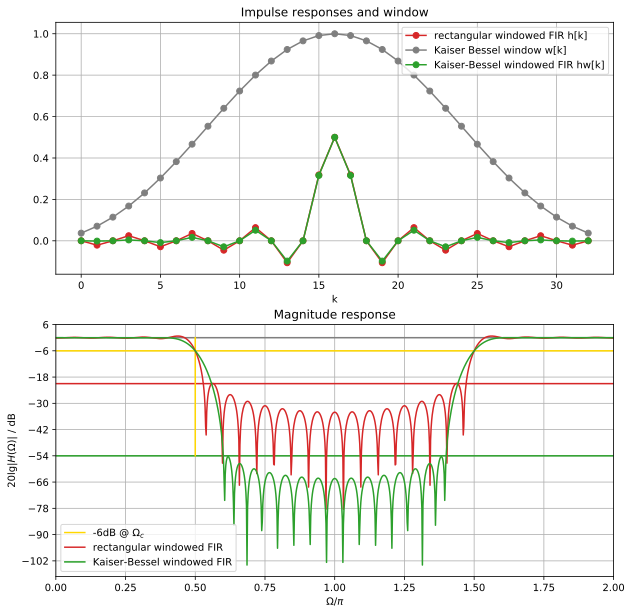

In [14]:
h = np.sin(Wc*(k-M//2)) / (np.pi*(k-M//2))
h[M//2] = Wc / np.pi
plot_windowed_FIR_design()

## Windowed FIR Design High-Pass

The ideal highpass (i.e. zero-phase and infinite impulse response) with cutoff frequency $0 < \Omega_c < \pi$ is given by inverse DTFT as

\begin{equation}
h[k] = \frac{1}{2 \pi} \int\limits_{\Omega_c}^{2\pi-\Omega_c} 1 \cdot \mathrm{e}^{+\mathrm{j} \Omega k} \mathrm{d}\Omega.
\end{equation}

The analytic solution is

\begin{equation}
h[k]=\frac{\sin\left(\pi k \right)}{\pi k}-\frac{\sin\left(\Omega_c k\right)}{\pi k}.
\end{equation}

In order to obtain a practical (finite order M) and causal (peak at M/2) we can shift this impulse response by $M/2$ (time delay)

\begin{equation}
h[k]=\frac{\sin\left(\pi\left(k-\frac{M}{2}\right)\right)}{\pi\left(k-\frac{M}{2}\right)}-\frac{\sin\left(\Omega_c\left(k-\frac{M}{2}\right)\right)}{\pi\left(k-\frac{M}{2}\right)}
\end{equation}

and consider only the values for $0\leq k \leq M$, so filter order $M$, filter length $M+1$. Furthermore, we require that $M$ is even to obtain linear-phase type I. Then we can simplify

\begin{equation}
h[k]=\begin{cases}
-\frac{\sin\left(\Omega_c\left(k-\frac{M}{2}\right)\right)}{\pi\left(k-\frac{M}{2}\right)} &\quad k\neq \frac{M}{2}\\
1-\frac{\Omega_c}{\pi} &\quad k=\frac{M}{2}.
\end{cases}
\end{equation}

Again, with an accordingly designed window for $0\leq k \leq M$, the improved FIR is given as

\begin{equation}
h_w[k] = w[k] \cdot h[k].
\end{equation}

Kaiser-Bessel window is also perfectly suited for the highpass. So we use precisely the same window as for the lowpass.

/Users/fs446/anaconda3/envs/mypy/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


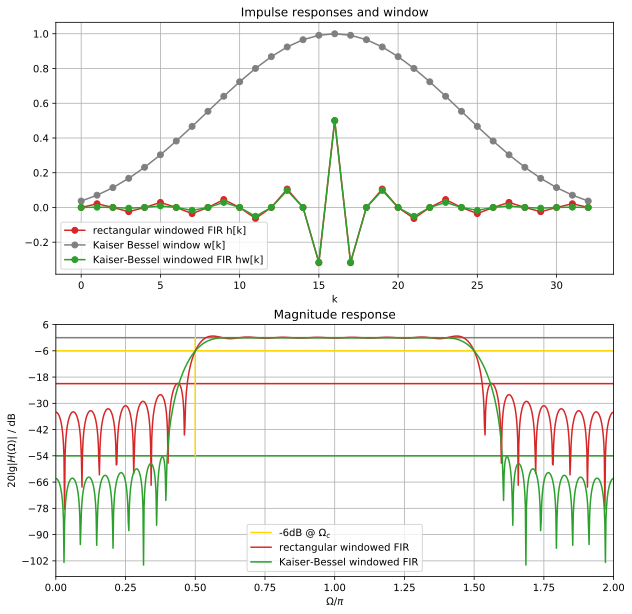

In [15]:
h = - np.sin(Wc*(k-M//2)) / (np.pi*(k-M//2))
h[M//2] = 1 - Wc/np.pi
plot_windowed_FIR_design()

Play around with $M$, $\Omega_c$, $\beta$ and how they are linked. Then, you're ready to study the FIR design methods in books in detail.

# **Copyright**

The notebooks are provided as [Open Educational Resources](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebooks for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Frank Schultz, Digital Signal Processing - A Tutorial Featuring Computational Examples* with the URL https://github.com/spatialaudio/digital-signal-processing-exercises